In [1]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [2]:
torch.manual_seed(1)

In [3]:
transformer = transforms.Compose([
    transforms.Resize(128),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_data = datasets.FashionMNIST(root=".", download=True, train=True, transform=transformer)
train_dataloader = DataLoader(dataset=train_data, batch_size=128, shuffle=True, num_workers=4)

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
for batch_images, batch_labels in train_dataloader:
    print("Batch Image Shape:", batch_images.shape)
    print("Batch Label Shape:", batch_labels.shape)
    break  # Only print the shape of the first batch


Batch Image Shape: torch.Size([128, 1, 128, 128])
Batch Label Shape: torch.Size([128])


In [5]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()

        self.label_conditioned = nn.Sequential(
            nn.Embedding(10,100),
            nn.Linear(100, 4*4)
        )

        self.latent = nn.Sequential(
            nn.Linear(100, 512*4*4)
        )

        self.model = nn.Sequential(
            nn.ConvTranspose2d(513, 64*8,kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64*8),
            nn.ReLU(),
            nn.ConvTranspose2d(64*8, 64*4,kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64*4),
            nn.ReLU(),
            nn.ConvTranspose2d(64*4, 74*2,kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(74*2),
            nn.ReLU(),
            nn.ConvTranspose2d(74*2, 74*1,kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(74*1),
            nn.ReLU(),
            nn.ConvTranspose2d(74*1, 1,kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh(),
        
        )
    
    def forward(self, input, vis=False):
        
        if not vis:
            noise, label = input
            label_output = self.label_conditioned(label)
            # print(label_output.shape)
            label_output = label_output.view(-1,1,4,4)

            latent_output = self.latent(noise)
            latent_output = latent_output.view(-1,512,4,4)

            concat = torch.cat((label_output, latent_output), 1)
        else:
            pass
        return self.model(concat)
    


In [6]:
# data = torch.randn(128, 512, 4, 4)
# data.view(-1, 1, 128, 128).shape
gen = Generator().to(device)
# output = gen(data)
# output.shape

In [7]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.label_condition = nn.Sequential(
            nn.Embedding(10, 100),
            nn.Linear(100, 1*128*128)
        )
             
        self.model = nn.Sequential(nn.Conv2d(2, 64, 4, 2, 1, bias=False),
                      nn.LeakyReLU(0.2, inplace=True),
                      nn.Conv2d(64, 64*2, 4, 3, 2, bias=False),
                      nn.BatchNorm2d(64*2, momentum=0.1,  eps=0.8),
                      nn.LeakyReLU(0.2, inplace=True),
                      nn.Conv2d(64*2, 64*4, 4, 3,2, bias=False),
                      nn.BatchNorm2d(64*4, momentum=0.1,  eps=0.8),
                      nn.LeakyReLU(0.2, inplace=True),
                      nn.Conv2d(64*4, 64*8, 4, 3, 2, bias=False),
                      nn.BatchNorm2d(64*8, momentum=0.1,  eps=0.8),
                      nn.LeakyReLU(0.2, inplace=True), 
                      nn.Flatten(),
                      nn.Dropout(0.4),
                      nn.Linear(4608, 1),
                      nn.Sigmoid()
                     )
    
    def forward(self, input):
        img, label = input
        label_output = self.label_condition(label)
        label_output = label_output.view(-1,1,128,128)
        concat = torch.cat((img, label_output), dim=1)
        return self.model(concat)

In [8]:
disc = Discriminator().to(device)
# testin = torch.randn(128,2,128,128)
# disc(testin).shape

In [9]:
def plot_image(image, title=None, nrow=5):
    img_show_fake = make_grid(image[:40], normalize=True, nrow=nrow)

    img_show_fake = img_show_fake.detach().cpu().permute(1, 2, 0).numpy()

    plt.imshow(img_show_fake)
    plt.title(title)
    plt.axis("off")
    plt.show()

In [10]:
loss_fn = nn.BCELoss()

learning_rate = 0.0002 

gen_opt = torch.optim.Adam(gen.parameters(), lr = learning_rate, betas=(0.5, 0.999))
disc_opt = torch.optim.Adam(disc.parameters(), lr = learning_rate, betas=(0.5, 0.999))

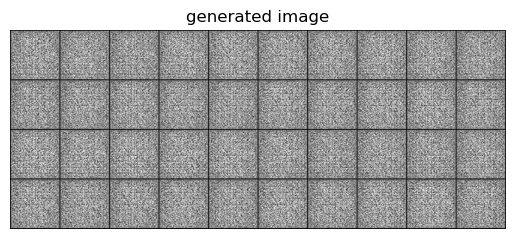

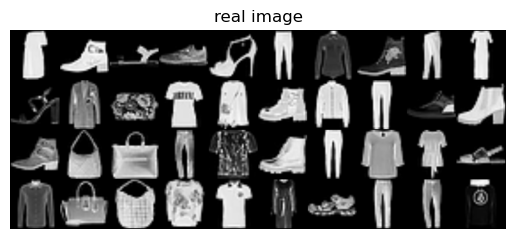

0


In [12]:
generator_losses = []
discriminator_losses = []
epochs = 2

for epoch in range(1 + epochs+1):

    for index, (real, labels) in enumerate(train_dataloader):
        batch_size = len(real)

        real = real.to(device)
        # print(labels.shape)
        labels = labels.to(device)
        labels = labels.unsqueeze(1).long()


        disc_opt.zero_grad()

        random_noise = torch.rand(batch_size, 100).to(device)

        fake = gen((random_noise, labels))

        fake_image_pred = disc((fake.detach(), labels))
        real_image_pred = disc((real, labels))


        disc_real_loss = loss_fn(real_image_pred, torch.ones_like(real_image_pred))
        disc_fake_loss = loss_fn(fake_image_pred, torch.zeros_like(fake_image_pred))
        disc_loss = (disc_fake_loss + disc_real_loss) / 2
        disc_loss.backward(retain_graph=True)
        disc_opt.step()

        discriminator_losses += [disc_loss.item()]

        gen_opt.zero_grad()


        gen_loss = loss_fn(disc((fake, labels)), torch.ones_like(real_image_pred))
        gen_loss.backward()
        gen_opt.step()

        generator_losses += [gen_loss.item()]

        if index %  100 == 0:
            plot_image(fake, 'generated image', nrow=10)
            plot_image(real, 'real image', nrow=10)
            print(f"{epoch}")

In [ ]:
n_inter = 10

def generate_latent(latent_dim, sample_dim):

    z_noise = torch.randn(sample_dim , latent_dim)

    return z_noise

def interpolate_points(p1, p2, n_inter=n_inter):

    ratios = torch.linspace(0, 1, steps=n_inter).reshape(-1, 1)
    
    vector = p1 * (1 - ratios) + ratios * p2
    
    return vector


s_g = generate_latent(100, 2)

interpolated = interpolate_points(s_g[0], s_g[1])
interpolated = interpolated.to(device)

for i in range(3):
    labels = torch.ones(n_inter) * i
    labels = labels.to(device)
    labels = labels.unsqueeze(1).long()

    prediction = gen((interpolated, labels))
    pred = prediction.detach().cpu()

    plot_image(pred, train_data.classes[i])

